<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек-и-датасетов" data-toc-modified-id="Загрузка-библиотек-и-датасетов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек и датасетов</a></span></li><li><span><a href="#Трансформация-признаков" data-toc-modified-id="Трансформация-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Трансформация признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Обучение-модели-на-всех-данных-из-файла" data-toc-modified-id="Обучение-модели-на-всех-данных-из-файла-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Обучение модели на всех данных из файла</a></span></li><li><span><a href="#Обучение-модели-на-числовых-признаках" data-toc-modified-id="Обучение-модели-на-числовых-признаках-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Обучение модели на числовых признаках</a></span></li></ul></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Анализ результатов</a></span></li></ul></li></ul></div>

# Предсказание стоимости жилья



В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. <br />

В колонках датасета содержатся следующие данные:<br />
- longitude — широта;<br />
- latitude — долгота;<br />
- housing_median_age — медианный возраст жителей жилого массива;<br />
- total_rooms — общее количество комнат в домах жилого массива;<br />
- тtotal_bedrooms — общее количество спален в домах жилого массива;<br />
- population — количество человек, которые проживают в жилом массиве;<br />
- households — количество домовладений в жилом массиве;<br />
- median_income — медианный доход жителей жилого массива;<br />
- median_house_value — медианная стоимость дома в жилом массиве;<br />
- ocean_proximity — близость к океану.<br />


На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

# План по выполнению проекта
- Инициализировать локальную Spark-сессию.<br />
- Прочитать содержимое файла /datasets/housing.csv.<br />
- Вывести типы данных колонок датасета, использовав методы pySpark.<br />
- Выполнить предобработку данных:<br />
 - Исследовать данные на наличие пропусков и заполните их, выбрав значения по своему усмотрению.<br />
 - Преобразовать колонку с категориальными значениями техникой One hot encoding.<br />
- Построить две модели линейной регрессии на разных наборах данных:<br />
 - используя все данные из файла;<br />
 - используя только числовые переменные, исключив категориальные.<br />
- Для построения модели использовать оценщик LinearRegression из библиотеки MLlib.<br />
- Сравните результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2. Сделать выводы.<br />


## Подготовка данных

### Загрузка библиотек и датасетов

In [1]:
import pandas as pd 
import numpy as np
import pyspark
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.stat import Correlation
from pyspark.mllib.evaluation import RegressionMetrics
RANDOM_SEED = 12345
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

In [3]:
df_housing = spark.read.load('/datasets/housing.csv', format = "csv", sep=",", inferSchema=True, header="True")
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Выведем названия колонок и их тип данных в виде таблицы:

In [4]:
print(pd.DataFrame(df_housing.dtypes, columns=['column', 'type']).head(10))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


Выведем первые 10 строк датасета методом DataFrame API:

In [5]:
df_housing.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [6]:
df_housing.toPandas().describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


В датасете примерно 21 тысяча строк. Максимальная медианная стоимость дома равна полумиллиону долларов. 

Выведем пропущенные значения в каждой колонке:

In [7]:
columns = df_housing.columns

for column in columns:
    check_col = F.col(column).cast(FloatType())
    print(column, df_housing.filter(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Пропуски есть в колонке total_bedrooms. Так как по условиям задачи необходимо использовать линейную регрессию, то пропуски следует заполнить.

In [8]:
df_housing.filter('total_bedrooms is NULL').groupBy('ocean_proximity').count().toPandas()

,ocean_proximity,count
0,NEAR OCEAN,30
1,NEAR BAY,20
2,<1H OCEAN,102
3,INLAND,55


In [9]:
num_columns = [c for c in df_housing.columns if c != 'ocean_proximity']
quantile_lst = df_housing.approxQuantile(num_columns, [0.25, 0.5, 0.75], 0)

quantile_df = pd.DataFrame(quantile_lst, columns=['quantile_25', 'quantile_50', 'quantile_75'])
quantile_df.index = num_columns

df_housing_describe = df_housing.select(*num_columns).describe().toPandas().set_index('summary').T.join(quantile_df)
columns_order_to_describe = ['count', 'mean', 'stddev','min', 'quantile_25', 'quantile_50', 'quantile_75', 'max']

display(df_housing_describe[columns_order_to_describe])

,count,mean,stddev,min,quantile_25,quantile_50,quantile_75,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-121.80,-118.49,-118.01,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,33.93,34.26,37.71,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,18.00,29.00,37.00,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,1447.00,2127.00,3148.00,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,296.00,435.00,647.00,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,787.00,1166.00,1725.00,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,280.00,409.00,605.00,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,2.56,3.53,4.74,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,119600.00,179700.00,264700.00,500001.0


In [10]:
quantile_lst = df_housing.filter('total_bedrooms is NULL').approxQuantile(num_columns, [0.25, 0.5, 0.75], 0)
quantile_df = pd.DataFrame(quantile_lst, columns=['quantile_25', 'quantile_50', 'quantile_75'])
quantile_df.index = num_columns

df_housing_describe_nans = df_housing.filter('total_bedrooms is NULL').select(*num_columns).describe().toPandas().set_index('summary').T.join(quantile_df)

display(df_housing_describe_nans[columns_order_to_describe])

,count,mean,stddev,min,quantile_25,quantile_50,quantile_75,max
longitude,207,-119.47256038647346,2.001423938482286,-124.13,-121.85,-118.49,-117.98,-114.59
latitude,207,35.49763285024152,2.097297776100012,32.66,33.96,34.20,37.51,40.92
housing_median_age,207,29.270531400966185,11.964926543525893,4.0,19.00,30.00,38.00,52.0
total_rooms,207,2562.6038647342993,1787.269788987037,154.0,1307.00,2155.00,3473.00,11709.0
total_bedrooms,0,None,None,None,NaN,NaN,NaN,None
population,207,1477.7729468599034,1057.4482115173646,37.0,781.00,1217.00,1891.00,7604.0
households,207,510.02415458937196,386.1207044990592,16.0,257.00,427.00,629.00,3589.0
median_income,207,3.8222439613526573,1.9555946874300458,0.8527,2.56,3.41,4.63,15.0001
median_house_value,207,206007.28019323671,111638.21454491059,45800.0,128100.00,175000.00,269300.00,500001.0


Какой-то закономерности в пропусках выявить не удалось. Так как пропусков всего один процент, то заполним такие значения медианным значением признака.

Получим медианное значение и выведем его на экран.

In [11]:
total_bedrooms_median = df_housing.approxQuantile('total_bedrooms', [0.5], 0)[0]

total_bedrooms_median

435.0

Заполним пропуски и проведем повторную проверку.

In [12]:
df_housing = df_housing.fillna(total_bedrooms_median, subset=['total_bedrooms'])
df_housing.select(
    [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_housing.columns]
    ).toPandas().T.rename(columns={0:'NA'})

,NA
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [13]:
df_housing.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20640,536.8388565891473,419.39187792168866,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


Рассмотрим также корреляцию признаков, исключив целевой и категориальный признаки.

Для этого будем использовать функцию корреляции в пакете **pyspark.ml.stat**. Между тем, требуется требуется перевести типы данных в столбцах в Vector, для конвертации данных будем использовать VectorAssembler, а затем применим корреляцию.

23/03/12 18:59:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/12 18:59:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


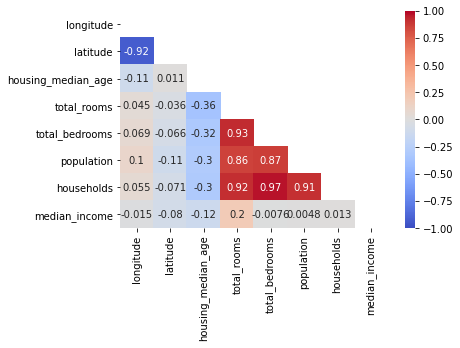

In [14]:
corr_columns = [c for c in num_columns if c != 'median_house_value']

vector_col = 'corr_features'
assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
df_vector = assembler.setHandleInvalid("skip").transform(df_housing[corr_columns]).select(vector_col)

#создаем матрицу
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

matrix_df = pd.DataFrame(cor_np, columns=corr_columns)
matrix_df.index = corr_columns

matrix_mask = np.triu(matrix_df)
sns.heatmap(matrix_df,
           annot=True,
     mask=matrix_mask,
              vmin=-1,
               vmax=1,
      cmap='coolwarm')
plt.show()

Найдём жилые массивы, в которых живут самые обеспеченные люди. Сгруппируем данные по столбцу с категориями удалённости от океана и посчитаем среднее значение медианного дохода в жилом массиве:

In [15]:
df_wealthy = df_housing.groupBy('ocean_proximity').agg(F.avg('median_income').alias('avg_median_income')).toPandas()
df_wealthy

,ocean_proximity,avg_median_income
0,ISLAND,2.74
1,NEAR OCEAN,4.01
2,NEAR BAY,4.17
3,<1H OCEAN,4.23
4,INLAND,3.21


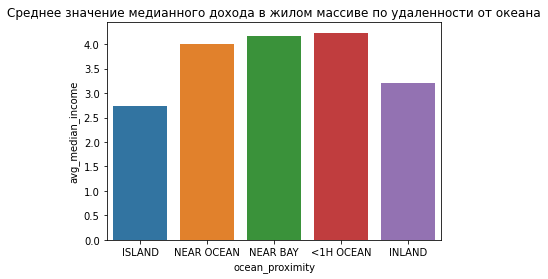

In [16]:
bar = sns.barplot(data = df_wealthy, x='ocean_proximity', y='avg_median_income')
bar.set_title("Cреднее значение медианного дохода в жилом массиве по удаленности от океана")
plt.show()

Ожидаемый результат: люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива.

Исследуем зависимость возраста жителей от удалённости жилого массива от океана. Сгруппируем данные по двум столбцам: медианный возраст жителей и удалённость от океана, а потом посчитаем сколько раз встречается то или иное медианное значение возраста в зависимости от удалённости от океана:

In [17]:
df_ages = df_housing.groupBy('housing_median_age', 'ocean_proximity').agg({'housing_median_age':'count'}).toPandas()
df_ages = df_ages.rename({'count(housing_median_age)':'count_households'},axis=1)
df_ages.head()

,housing_median_age,ocean_proximity,count_households
0,23.00,<1H OCEAN,195
1,31.00,NEAR BAY,41
2,11.00,<1H OCEAN,83
3,36.00,<1H OCEAN,477
4,10.00,INLAND,151


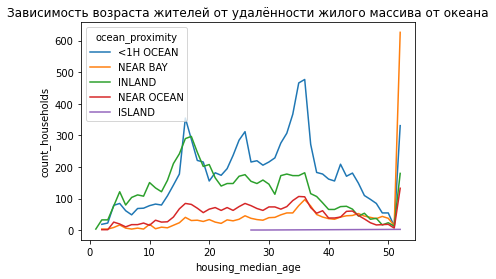

In [18]:
age_bar = sns.lineplot(data=df_ages, 
    x='housing_median_age', 
    y='count_households', 
    hue='ocean_proximity'
)
age_bar.set_title("Зависимость возраста жителей от удалённости жилого массива от океана")
plt.show()

По графику можно предположить, что люди до 20 лет чаще живут в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Старшие поколения предпочитают селиться в радиусе часа езды до океана и около залива.

Создадим несколько новых столбцов с признаками: 

- Отношение количества комнат `total_rooms` к количеству домовладений `households`. Назовите колонку `rooms_per_household`.
- Отношение количества жителей `population` к количеству домовладений `households`. Назовите колонку `population_in_household`.
- Отношение количества спален `total_bedrooms` к общему количеству комнат `total_rooms`. Назовите колонку `bedroom_index`.

In [19]:
df_housing = df_housing.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
df_housing = df_housing.withColumn('population_in_household', F.col('population') / F.col('households'))
df_housing = df_housing.withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



Были созданы новые колонки, которые могут быть подходящими признаками для модели машинного обучения.

Разделим колонки на два типа: числовые и текстовые, которые представляют категориальные данные.

In [20]:
categorical_cols = ['ocean_proximity']
numerical_cols  = [c for c in num_columns if c != 'median_house_value']
target = 'median_house_value'

**Выводы:**

- Среди жилых массивов есть такие, где всего лишь один дом;
- Есть жилые массивы, где всего 3 человека проживает;
- В столбце total_bedrooms есть пропуски, которые были заполнены медианным значением;
- В данных есть выбросы. Если при обучении модели наличие выбросов будет серьезно искажать результаты, то от них стоит избавиться.

Высокой корреляцией между собой: количество домовладений в массиве и количество спален, наряду с количеством комнат и количество человек, которые проживают в жилом массиве. Также стоит отметить корреляцию между количеством комнат и количеством спален, можно предположить, что от одного из этих признаков можно будет избавиться.

### Трансформация признаков

Трансформируем категориальные признаки с помощью трансформера StringIndexer:

In [21]:
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols])
df_housing = indexer.fit(df_housing).transform(df_housing)
cols = [c for c in df_housing.columns for i in categorical_cols if (c.startswith(i))]
df_housing.select(cols).show(3)

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
+---------------+-------------------+
only showing top 3 rows



Дополнительно сделаем OHE-кодирование для категорий:

In [22]:
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols], 
                        outputCols=[c+'_ohe' for c in categorical_cols])
df_housing = encoder.fit(df_housing).transform(df_housing)
cols = [c for c in df_housing.columns for i in categorical_cols if (c.startswith(i))]
df_housing.select(cols).show(3) 

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



Финальный шаг преобразований — это объединение признаков в один вектор, с которым ML-алгоритм умеет работать:

In [23]:
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                        outputCol='categorical_features')
df_housing = categorical_assembler.transform(df_housing) 

In [24]:
pd.DataFrame(df_housing.take(3),
             columns=df_housing.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_in_household,bedroom_index,ocean_proximity_idx,ocean_proximity_ohe,categorical_features
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY,6.98,2.56,0.15,3.00,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY,6.24,2.11,0.16,3.00,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY,8.29,2.80,0.13,3.00,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"


Для числовых признаков тоже нужна трансформация — шкалирование значений — чтобы сильные выбросы не смещали предсказания модели

In [25]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                      outputCol='numerical_features')
df_housing = numerical_assembler.transform(df_housing)

In [26]:
standardScaler = StandardScaler(inputCol='numerical_features',
                                outputCol='numerical_features_scaled')
df_housing = standardScaler.fit(df_housing).transform(df_housing) 

После всех трансформаций получается такие колонки в таблице df_housing:

In [27]:
df_housing.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string'),
 ('rooms_per_household', 'double'),
 ('population_in_household', 'double'),
 ('bedroom_index', 'double'),
 ('ocean_proximity_idx', 'double'),
 ('ocean_proximity_ohe', 'vector'),
 ('categorical_features', 'vector'),
 ('numerical_features', 'vector'),
 ('numerical_features_scaled', 'vector')]

Финальный шаг — собрать трансформированные категорийные и числовые признаки с помощью VectorAssembler:

In [28]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='all_features') 
df_housing = final_assembler.transform(df_housing)
df_housing.select('all_features').show(3)

+--------------------+
|        all_features|
+--------------------+
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
+--------------------+
only showing top 3 rows



На этапе обучения моделей нам предстоит построить две модели линейной регрессии на разных наборах данных:<br />
- используя все данные из файла;<br />
- используя только числовые переменные, исключив категориальные.<br />

Подготовим для этого два датасета.<br />

In [29]:
df_all = df_housing.select(['all_features','median_house_value'])
df_all.show(3)

+--------------------+------------------+
|        all_features|median_house_value|
+--------------------+------------------+
|[0.0,0.0,0.0,1.0,...|          452600.0|
|[0.0,0.0,0.0,1.0,...|          358500.0|
|[0.0,0.0,0.0,1.0,...|          352100.0|
+--------------------+------------------+
only showing top 3 rows



In [30]:
df_numerical = df_housing.select(['numerical_features_scaled','median_house_value'])
df_numerical.show(3)

+-------------------------+------------------+
|numerical_features_scaled|median_house_value|
+-------------------------+------------------+
|     [-61.007269596069...|          452600.0|
|     [-61.002278409814...|          358500.0|
|     [-61.012260782324...|          352100.0|
+-------------------------+------------------+
only showing top 3 rows



В процессе загрузки датасетов, пребобработки данных и трансформации признаков было выявлено:<br />
- Проверены пропуски (найдено 207 пропусков в столбец total_bedrooms), строки, в которых есть пропущенные значения были заменены на медианные значения.<br />
- Найдены жилые массивы, в которых живут самые обеспеченные люди, сгруппированы данные по столбцу с категориями удалённости от океана и посчитано среднее значение медианного дохода в жилом массиве. На основе полученных данных можно сделать вывод, что люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива.<br />
- Исследована зависимость возраста жителей от удалённости жилого массива от океана и сгруппированы данные по двум столбцам: медианный возраст жителей и удалённость от океана, а потом было посчитано, сколько раз встречается то или иное медианное значение возраста в зависимости от удалённости от океана. Построен график, по которому можно предположить, что люди до 20 лет чаще живут в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Старшие поколения предпочитают селиться в радиусе часа езды до океана и около залива.<br />
- Созданы несколько новых столбцов с признаками:<br />
 - Отношение количества комнат total_rooms к количеству домовладений households. Столбец rooms_per_household.<br />
 - Отношение количества жителей population к количеству домовладений households. Столбец population_in_household.<br />
 - Отношение количества спален total_bedrooms к общему количеству комнат total_rooms. Столбец bedroom_index<br />

### Обучение моделей

#### Разделение на выборки

Разделим наш датасет на две части — выборку для обучения и выборку для тестирования качества модели.

In [31]:
df_all_train, df_all_test = df_all.randomSplit([.75,.25], seed=RANDOM_SEED)
print(f'Обучающая выборка: {df_all_train.count()} строк, {len(df_all_train.columns)} столбца',
      f'\nТестовая выборка: {df_all_test.count()} строк, {len(df_all_test.columns)} столбца')

Обучающая выборка: 15406 строк, 2 столбца 
Тестовая выборка: 5234 строк, 2 столбца


In [32]:
df_num_train, df_num_test = df_numerical.randomSplit([.75,.25], seed=RANDOM_SEED)
print(f'Обучающая выборка: {df_num_train.count()} строк, {len(df_num_train.columns)} столбца',
      f'\nТестовая выборка: {df_num_test.count()} строк, {len(df_num_test.columns)} столбца')

Обучающая выборка: 15406 строк, 2 столбца 
Тестовая выборка: 5234 строк, 2 столбца


#### Обучение модели на всех данных из файла

In [33]:
lr = LinearRegression(labelCol=target, featuresCol = 'all_features')
lr_model = lr.fit(df_all_train)

23/03/12 19:00:03 WARN Instrumentation: [0ded5016] regParam is zero, which might cause numerical instability and overfitting.
23/03/12 19:00:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/03/12 19:00:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Подведем итог модели по набору обучающих данных и распечатаем некоторые показатели:

In [34]:
training_summary = lr_model.summary

In [35]:
print("RMSE на тренировочных данных: %f" % training_summary.rootMeanSquaredError)
print("R2 на тренировочных данных: %f" % training_summary.r2)
print("MAE на тренировочных данных: %f" % training_summary.meanAbsoluteError)

RMSE на тренировочных данных: 68707.073514
R2 на тренировочных данных: 0.643731
MAE на тренировочных данных: 49610.466695


RMSE измеряет разницу между прогнозируемыми значениями по модели и фактическими значениями. Однако одно только RMSE не имеет смысла, пока мы не сравним с фактическим значением «median_house_value», таким как среднее, минимальное и максимальное

In [36]:
df_all_train.describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             15406|
|   mean|206498.85239517072|
| stddev|115113.60008727331|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



После такого сравнения наша RMSE выглядит довольно хорошо. Это говорит нам о том, что модель способна достаточно точно предсказывать цены на жилье, в пределах 69 тыс. дол.

In [37]:
lr_predictions = lr_model.transform(df_all_test)
lr_predictions.select('prediction','median_house_value','all_features').show(5)
test_result = lr_model.evaluate(df_all_test)
print("Среднеквадратическая ошибка (RMSE) на тестовой выборке = %g" % test_result.rootMeanSquaredError)



+------------------+------------------+--------------------+
|        prediction|median_house_value|        all_features|
+------------------+------------------+--------------------+
|333401.13179015345|          414300.0|[0.0,0.0,0.0,1.0,...|
|439843.95807471615|          463500.0|[0.0,0.0,0.0,1.0,...|
| 391701.6036533064|          500001.0|[0.0,0.0,0.0,1.0,...|
|295199.45815330814|          345700.0|[0.0,0.0,0.0,1.0,...|
|346238.84437728743|          500001.0|[0.0,0.0,0.0,1.0,...|
+------------------+------------------+--------------------+
only showing top 5 rows



Среднеквадратическая ошибка (RMSE) на тестовой выборке = 68796.9


In [38]:
lr_evaluator = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='median_house_value',metricName='r2')
print("R2 на тестовых данных = %g" % lr_evaluator.evaluate(lr_predictions))

R2 на тестовых данных = 0.649562


In [39]:
lr_evaluator_mae = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='median_house_value',metricName='mae')
print("MAE на тестовых данных = %g" % lr_evaluator_mae.evaluate(lr_predictions))

MAE на тестовых данных = 50347.9


#### Обучение модели на числовых признаках

In [40]:
lr_num = LinearRegression(labelCol=target, featuresCol = 'numerical_features_scaled')
lr_model_num = lr_num.fit(df_num_train)

23/03/12 19:00:10 WARN Instrumentation: [54c12c39] regParam is zero, which might cause numerical instability and overfitting.


Подведем итог модели по набору обучающих данных и распечатаем некоторые показатели:

In [41]:
training_summary_num = lr_model_num.summary

In [42]:
print("RMSE на тренировочных данных: %f" % training_summary_num.rootMeanSquaredError)
print("R2 на тренировочных данных: %f" % training_summary_num.r2)
print("MAE на тренировочных данных: %f" % training_summary_num.meanAbsoluteError)

RMSE на тренировочных данных: 70165.530150
R2 на тренировочных данных: 0.629273
MAE на тренировочных данных: 51303.532481


Так же сравним RMSE с фактическим значением «median_house_value»:

In [43]:
df_num_train.describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             15406|
|   mean| 207063.3730364793|
| stddev| 115242.0680417819|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



R2 = 0,63 указывает, что в нашей модели, количества отклонений в прогнозах, объясненных набором данных составляет 63%, против 64% на полном наборе данных. Модель способна достаточно точно предсказывать цены на жилье, в пределах 70,1 тыс. дол, против 68,7 тыс. дол на полном наборе данных.

In [44]:
lr_predictions_num = lr_model_num.transform(df_num_test)
lr_predictions_num.select('prediction','median_house_value','numerical_features_scaled').show(5)
test_result_num = lr_model_num.evaluate(df_num_test)
print("Среднеквадратическая ошибка (RMSE) на тестовых данных = %g" % test_result_num.rootMeanSquaredError)

+------------------+------------------+-------------------------+
|        prediction|median_house_value|numerical_features_scaled|
+------------------+------------------+-------------------------+
|189459.40212413995|          106700.0|     [-62.005506847089...|
|173865.57810855052|          128900.0|     [-61.975559729558...|
|199936.73051977484|          116100.0|     [-61.975559729558...|
|130502.63657675171|           70500.0|     [-61.975559729558...|
| 155130.5725637339|           85600.0|     [-61.970568543303...|
+------------------+------------------+-------------------------+
only showing top 5 rows

Среднеквадратическая ошибка (RMSE) на тестовых данных = 68223.1


In [45]:
lr_evaluator_num = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='median_house_value',metricName='r2')
print("R2 на тестовых данных = %g" % lr_evaluator_num.evaluate(lr_predictions_num))

R2 на тестовых данных = 0.653172


In [46]:
lr_evaluator_num_mae = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='median_house_value',metricName='mae')
print("MAE на тестовых данных = %g" % lr_evaluator_num_mae.evaluate(lr_predictions_num))

MAE на тестовых данных = 50194.7


**При построении модели линейной регрессии на всех данных были получены следующие результаты:**

**RMSE**<br />
на тренировочных данных = 68707.1 <br />
на тестовой выборке = 68796.9 <br />
**R2**<br />
на тренировочных данных = 0.643731 <br />
на тестовых данных = 0.649562 <br />
**MAE**<br />
на тренировочных данных: 49610.5 <br />
на тестовых данных = 50347.9 <br />

**При построении модели линейной регрессии только на числовых данных были получены следующие результаты:**

**RMSE**<br />
на обучающих данных = 70165.5 <br />
на тестовых данных = 68223.1 <br />
**R2**<br />
на тренировочных данных = 0.629273 <br />
на тестовых данных = 0.653172 <br />
**MAE**<br />
на тренировочных данных: 51303.5 <br />
на тестовых данных = 50194.7 <br />

### Анализ результатов

Выведем полученные на тестовом датасете метрики в виде таблицы.

In [47]:
train, test = df_housing.select(['all_features',
                                 'numerical_features_scaled',
                                 'median_house_value']).randomSplit([.75, .25], seed=RANDOM_SEED)
print(f'Обучающая выборка: {train.count()} строк, {len(train.columns)} столбца',
      f'\nТестовая выборка:, {test.count()} строк, {len(test.columns)} столбца')

Обучающая выборка: 15406 строк, 3 столбца 
Тестовая выборка:, 5234 строк, 3 столбца


In [48]:
# Создаем список, куда будем вносить результаты
data_table = [
    ['features_used', 'RMSE', 'R2', 'MAE']
]

# Перебираем варианты используемых признаков
for col in ['all_features', 'numerical_features_scaled']:
    # обучаем модель
    lr = LinearRegression(labelCol=target, featuresCol=col)
    model = lr.fit(train)
    
    #запишем предсказания на тестовой выборке
    predictions = model.transform(test)
    
    #выделим предсказания и ответы в отдельную переменную
    results = predictions.select(['prediction', target])
    
    #соберем все в RDD
    results_collect = results.collect()
    results_list = [ (float(i[0]), float(i[1])) for i in results_collect]
    scoreAndLabels = spark.sparkContext.parallelize(results_list)
    
    #запишем метрики в отдельную переменную
    metrics = RegressionMetrics(scoreAndLabels)
    
    #добавим результаты в список
    data_table.append([col,
                       metrics.rootMeanSquaredError,
                       metrics.r2,
                       metrics.meanAbsoluteError])

23/03/12 19:00:15 WARN Instrumentation: [688c10c3] regParam is zero, which might cause numerical instability and overfitting.
23/03/12 19:00:19 WARN Instrumentation: [41f7b510] regParam is zero, which might cause numerical instability and overfitting.


In [49]:
pd.DataFrame(data_table[1:], columns=data_table[0])

,features_used,RMSE,R2,MAE
0,all_features,68796.92,0.65,50347.88
1,numerical_features_scaled,69514.37,0.64,51262.48


В ходе работы было использовано два метода обучения моделей: с формированием вспомогательных датасетов и без. Исходя из полученных результатов, можно сказать, что модель со всеми признаками без исключений обучилась и предсказывает результаты одинаково, метрики совпадают. Однако, если брать метрики модели, которая обучалась только на числовых данных, то в этом случае покзатели метрик расходятся. Получается как раз, что df_all_train совпадает с train, а df_num_train нет, поэтому есть разница в результатах, randomSplit работает немного по другому, если первым указать численные признаки, то train разобьется по другому, и вторая часть таблицы в этом случае будет совпадать полностью.

Исходя из полученных результатов, можно сказать, что модель со всеми признаками без исключений обучилась и предсказывает результаты лучше, чем только на числовых. На тестовой выборке было достигнуто значение метрики R2 0.65. 
